In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg

from tqdm import tqdm

plt.style.use('science')

# Explicit Approach

In [71]:
class System:
    
    def __init__(self, EJ=2, EC=2, ng=0.5, flux=0, ncut=10):
        self.EJ = EJ                               # Josephson energy
        self.EC = EC                               # Josephson capacitance energy
        self.ng = ng                               # Reduced gate charge
        self.flux = flux                           # Flux through qubit
        self.ncut = ncut                           # Cut-off threshold for number basis
        
        self.init_operators()
        
    def _print_params(self):
        print(f'EJ:    {self.EJ}')
        print(f'EC:    {self.EC}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')
    
    def init_operators(self):
        self.I_cb = np.diag(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        
        self.n_op_cb = np.diag(np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))               # Charge operator (charge basis)
        self.ng_op_cb = self.ng * self.I_cb
        self.e_iphi_op_cb = np.diag(np.ones(2 * self.ncut, dtype=np.complex_), k=1)                                       # e^{i \phi} operator (charge basis)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def kin_mat(self):
        self.init_operators()
        kin_mat = self.EC * (self.n_op_cb - self.ng_op_cb) @ (self.n_op_cb - self.ng_op_cb)

        return kin_mat

    def pot_mat(self):
        self.init_operators()
        pot_mat = -self.EJ * (self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        
        return pot_mat

    def get_H(self):
        self.H = self.kin_mat() + self.pot_mat()
        
        return self.H
    
    def diagonalise(self, update=False, N=1):
        if update:
            self.get_H()
        else:
            try:
                self.H
            except AttributeError:
                self.get_H()
        self.evals, self.evecs = sp.linalg.eigh(
            self.H, eigvals=(0, N), eigvals_only=False
        )
        self.evecs = self.evecs.T
        
        return self.evals, self.evecs
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise(update=True)
        else:
            try:
                self.evecs
            except AttributeError:
                self.diagonalise()

        self.qubit_0 = self.evecs[0]
        self.qubit_1 = self.evecs[1]
        self.qubit_m = 2**-0.5 * (self.qubit_0 - self.qubit_1)
        self.qubit_p = 2**-0.5 * (self.qubit_0 + self.qubit_1)

## Varying $\text{n}_\text{g}$

In [108]:
ngs = np.linspace(-2, 2, 100)
E_0, E_1, E_2 = [], [], []

sys = System(ncut=20, EJ=1, EC=1, ng=0.5)

evals, evecs = sys.diagonalise(N=2, update=True)

E10 = evals[1] - evals[0]

for ng in tqdm(ngs):
    sys.ng = ng
    
    evals, evecs = sys.diagonalise(N=2, update=True)
    
    E_0.append(evals[0] / E10)
    E_1.append(evals[1] / E10)
    E_2.append(evals[2] / E10)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1559.82it/s]


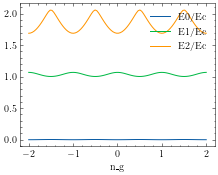

In [112]:
zero_E = min(E_0)

plt.plot(ngs, [val - zero_E for val in E_0], label='E0/Ec')
plt.plot(ngs, [val - zero_E for val in E_1], label='E1/Ec')
plt.plot(ngs, [val - zero_E for val in E_2], label='E2/Ec')
plt.xlabel('n_g')
plt.legend()
plt.show()

In [142]:
ngs = np.linspace(-0.25, 1.25, 10000)
Ejs = [0.1, 0.5, 1, 10]
E_0, E_1, E_2 = {}, {}, {}

sys = System(ncut=20, EC=1)

for Ej in Ejs:
    sys.EJ = Ej
    E_0[Ej], E_1[Ej], E_2[Ej] = [], [], []
    
    sys.ng=0.5
    evals, evecs = sys.diagonalise(N=2, update=True)
    E10 = evals[1] - evals[0]

    for ng in tqdm(ngs):
        sys.ng = ng

        evals, evecs = sys.diagonalise(N=2, update=True)

        E_0[sys.EJ].append(evals[0] / E10)
        E_1[sys.EJ].append(evals[1] / E10)
        E_2[sys.EJ].append(evals[2] / E10)

100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2403.17it/s]


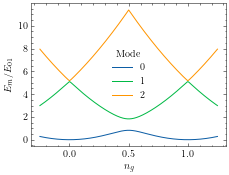

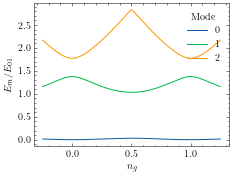

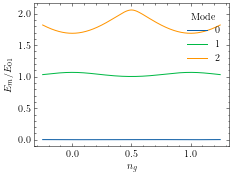

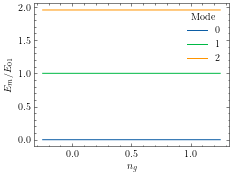

In [143]:
for Ej in Ejs:
    zero_E = min(E_0[Ej])
    plt.plot(ngs, [val - zero_E for val in E_0[Ej]], label='0')
    plt.plot(ngs, [val - zero_E for val in E_1[Ej]], label='1')
    plt.plot(ngs, [val - zero_E for val in E_2[Ej]], label='2')
    plt.xlabel('$n_g$')
    plt.ylabel('$$E_m / E_{01}$$')
    plt.legend(title='Mode')
    plt.savefig(f'figures/General/EJ({Ej}) EC({sys.EC}) spectrum.png', dpi=300)
    plt.show()